## ANALYZING TOXIC COMMENTS ON WIKIPEDIA
By Xiangzhen He, Katherine Hurtado-Da Silva, Jazmin Logroño

Machine learning algorithms, like Latent Dirichlet Allocation (LDA), K-Means Clustering, Multinomial Naïve Bayes, and Support Vector Machines (SVM) can help identify toxic comments posted online. Additionally, those algorithms can help in identifying patterns to detect toxic behavior. This analysis aims to answer the following questions: How well does each algorithm learn patterns to identify differences between toxic and non-toxic comments? What types of toxicity exist in toxic comments? Which words contribute to toxic comments? Are there different levels of toxicity?

The Kaggle toxic comment training data set provided by the Conversation AI team, a research initiative founded by Jigsaw and Google, will be used in this report. (data source: https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/overview)

This python script references code provided by the professor of IST 736 at Syracuse University. The document only reflects individual portion of the project.

In [10]:
##### Load libraries
import pandas as pd
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random
import seaborn as sb

from sklearn.decomposition import LatentDirichletAllocation

### Data Preparation

In [2]:
#the file path below needs to be updated when using by different users
#Data obtained from https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/overview
address = "/Users/zhen/Documents/DS@Syracuse/Q4/IST 736/Project/train.csv"

toxicdf = pd.read_csv(address, sep=',')

#check the data
print(toxicdf.shape)
print(toxicdf[0:10])

(159571, 8)
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   
5  00025465d4725e87  "\n\nCongratulations from me as well, use the ...      0   
6  0002bcb3da6cb337       COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK      1   
7  00031b1e95af7921  Your vandalism to the Matt Shirvington article...      0   
8  00037261f536c51d  Sorry if the word 'nonsense' was offensive to ...      0   
9  00040093b2687caa  alignment on this subject and which are contra...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0      

In [4]:
#check if there are null values in data set
print(toxicdf.isnull().sum())

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [5]:
#Check the number of observations in each column.
print(toxicdf['toxic'].value_counts())
print(toxicdf['severe_toxic'].value_counts())
print(toxicdf['obscene'].value_counts())
print(toxicdf['threat'].value_counts())
print(toxicdf['insult'].value_counts())
print(toxicdf['identity_hate'].value_counts())

0    144277
1     15294
Name: toxic, dtype: int64
0    157976
1      1595
Name: severe_toxic, dtype: int64
0    151122
1      8449
Name: obscene, dtype: int64
0    159093
1       478
Name: threat, dtype: int64
0    151694
1      7877
Name: insult, dtype: int64
0    158166
1      1405
Name: identity_hate, dtype: int64


In [6]:
#Create a label column based on the number of toxicity label assigned to the comment
toxicdf['label']=toxicdf['toxic']+toxicdf['severe_toxic']+toxicdf['obscene']+toxicdf['threat']+toxicdf['insult']+toxicdf['identity_hate']

#Check the number of observations in each label class
print(toxicdf['label'].value_counts()) 

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: label, dtype: int64


In [7]:
#create length variable that saves the length of each comment
length = toxicdf.comment_text.apply(len)

#check the statistics of length
length.describe()

#remove records with a length less or equal to 10
toxicdf['length'] = length
toxicdf_new = toxicdf[toxicdf.length > 10]

In [9]:
#check the observations in toxic column again
print(toxicdf_new['toxic'].value_counts())

#check again the distribution of label column
print('\n')
print(toxicdf_new['label'].value_counts()) 

0    144274
1     15292
Name: toxic, dtype: int64


0    143343
1      6360
3      4208
2      3480
4      1759
5       385
6        31
Name: label, dtype: int64


[]

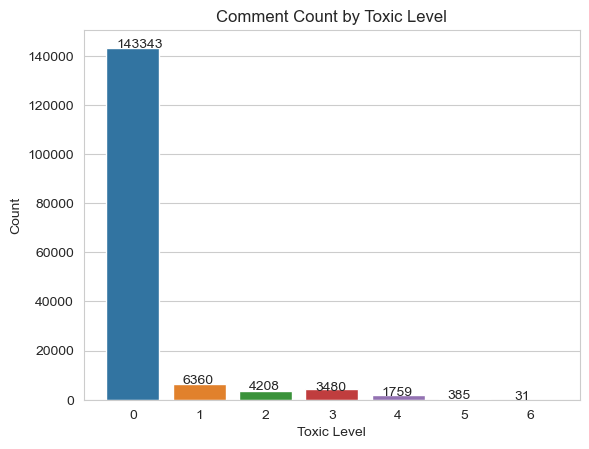

In [15]:
#create a bar plot for class labels
sb.set_style('whitegrid')
sb.countplot(data=toxicdf_new, x = 'label')
xlocs=[i for i in range(0,7)]
for i, v in enumerate(toxicdf_new['label'].value_counts()):
    plt.text(xlocs[i] - 0.25, v + 0.1, str(v))
plt.title('Comment Count by Toxic Level')
plt.xlabel('Toxic Level')
plt.ylabel('Count')
plt.plot()

In [16]:
##########Create the final dataset that only includes equal number of comments which have 0 or 1 label values
#Get subset of data for any comment that has no toxicity
toxicdf_no =toxicdf_new.loc[toxicdf_new['label']==0]

#random select 50% of the data
random.seed(11)
toxicdf_no = toxicdf_no.sample(n=6360)

#Get subset of data for any comment that has label value of 1
toxicdf_yes1 = toxicdf_new.loc[toxicdf_new['label']==1]

In [17]:
# merge two data frames
print('First 10 rows of the final data frame merging:')
finaldf = pd.concat([toxicdf_yes1, toxicdf_no], axis=0)
#check the first 10 rows
print(finaldf[0:10])

#check the dimensions of the final dataframe
print(finaldf.shape)

First 10 rows of the final data frame merging:
                   id                                       comment_text  \
12   0005c987bdfc9d4b  Hey... what is it..\n@ | talk .\nWhat is it......   
16   0007e25b2121310b  Bye! \n\nDon't look, come or think of comming ...   
44   001956c382006abd  I'm Sorry \n\nI'm sorry I screwed around with ...   
59   002264ea4d5f2887  Why can't you believe how fat Artie is? Did yo...   
151  005f59485fcddeb0  "\n\nSORRY PUCK BUT NO ONE EVER SAID DICK WAS ...   
159  00637960a7ec3436  "\n\nUNBLOCK ME OR I'LL GET MY LAWYERS ON TO Y...   
179  006d11791d76b9f3  REPLY ABOVE:\nThat was me, loser. The UN defin...   
206  0082b5a7b4a67da2  Give me a permanat block raseac....!!! remembe...   
268  00ab65775c601cf9                       Atheism is full of bias shit   
278  00afb4dec99a231f  Hey why you are spreading misconceptions and t...   

     toxic  severe_toxic  obscene  threat  insult  identity_hate  label  \
12       1             0        0       0

In [18]:
#Check the observations in each column in the new dataframe
print(finaldf['toxic'].value_counts())
print(finaldf['severe_toxic'].value_counts())
print(finaldf['obscene'].value_counts())
print(finaldf['threat'].value_counts())
print(finaldf['insult'].value_counts())
print(finaldf['identity_hate'].value_counts())

#save comment text and toxic labels to new variables
comments = finaldf['comment_text'].values
labels = finaldf['label'].values

0    7054
1    5666
Name: toxic, dtype: int64
0    12720
Name: severe_toxic, dtype: int64
0    12403
1      317
Name: obscene, dtype: int64
0    12698
1       22
Name: threat, dtype: int64
0    12419
1      301
Name: insult, dtype: int64
0    12666
1       54
Name: identity_hate, dtype: int64


In [19]:
#create a dataframe for the new data
final_toxicdf = pd.DataFrame(data = comments, columns = ['Comments'])
final_toxicdf.insert(loc = 0, column = 'Labels', value = labels)

### Data Cleaning and Exploration

In [20]:
#Remove \n character 
comments = [c.replace('\n', '') for c in comments]

#Remove urls starting with http
comments_new = [re.sub(r'http\S+', ' ', c) for c in comments]

#Remove urls starting with www
comments_new = [re.sub(r'www\S+', ' ', c) for c in comments_new]

#Check some toxic comments
print(comments_new[:10])

#Check some non-toxic tomments
print(comments_new[7500:7505])

['Hey... what is it..@ | talk .What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?Ask Sityush to clean up his behavior than issue me nonsensical warnings...', "Bye! Don't look, come or think of comming back! Tosser.", "I'm Sorry I'm sorry I screwed around with someones talk page.  It was very bad to do.  I know how having the templates on their talk page helps you assert your dominance over them.  I know I should bow down to the almighty administrators.  But then again, I'm going to go play outside....with your mom.   76.122.79.82", "Why can't you believe how fat Artie is? Did you see him on his recent appearence on the Tonight Show with Jay Leno? He looks absolutely AWFUL! If I had to put money on it, I'd say that Artie Lange is a can't miss candidate for the 2007 Dead pool!     Kindly keep your malicious fingers off of my abo

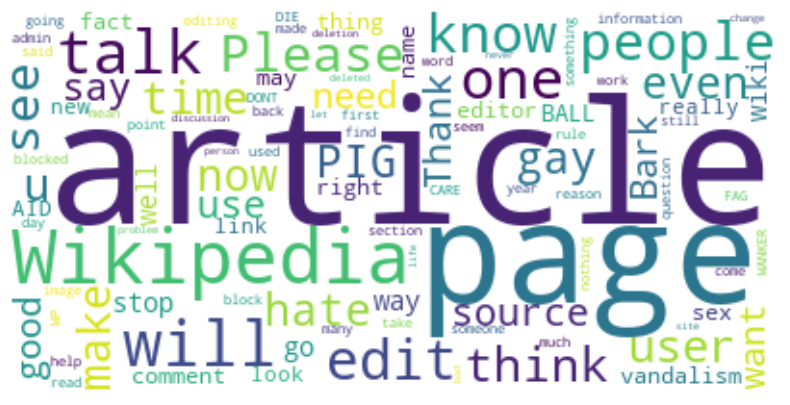

In [21]:
##Create a word cloud to review the most frequently appearing words
#Join all comments into one text document
commentstext = " ".join(comments_new)
    
#Create and generate a word cloud image
wordcloud = WordCloud(max_words=100, background_color="White",random_state=1, collocations=False).generate(commentstext)

# Display the generated image
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [22]:
###Create a boxplot to show distribution of phrase length in each sentiment class
#create comment_len variable that saves the length of each headline
comment_len = [len(c) for c in comments_new]

#get list of tuples from two lists
comment_len_tuples = list(zip(comment_len,labels))
comment_len_DF = pd.DataFrame(comment_len_tuples, columns=['comment_len','label'])

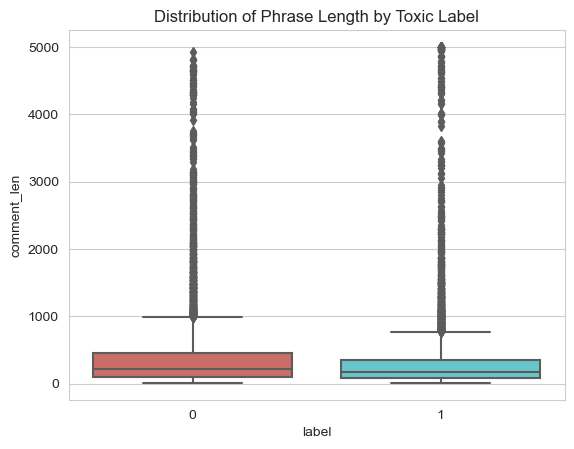

In [23]:
#create a boxplot to show distribution of phrase length in each class
sb.set_style('whitegrid')
sb.boxplot(x='label',y='comment_len', data = comment_len_DF, palette='hls')
plt.title('Distribution of Phrase Length by Toxic Label')
plt.show()

### General Text preprocessing

In [24]:
## First create a stemmer and a lemmatizer that will be used when transform text data into vectors
# from nltk.stem.porter import PorterStemmer
# porter = PorterStemmer()

from nltk.stem import WordNetLemmatizer
Lemmer=WordNetLemmatizer()  

# def MY_STEMMER(str_input):
#     words = re.sub(r"[^A-Za-z]", " ", str_input).lower().split()  
#     words = [porter.stem(w) for w in words]
#     words = [w for w in words if len(w) > 2]
#     return words

def MY_LEMMER(str_input):   
    words = re.sub(r"[^A-Za-z]", " ", str_input).lower().split()  
    words = [Lemmer.lemmatize(w) for w in words]
    words = [w for w in words if len(w) > 2] #remove words that have less than 3 characters
    return words

## Lastly, define a function to be used inside vectorizer to limit the length of the words
def LONG_WORDS(str_input):   
    words = re.sub(r"[^A-Za-z]", " ", str_input).lower().split()  
    words = [w for w in words if len(w) > 2]
    return words


## Different models will be using different vectorizers.
## Therefore, vectorization processes will be performed under the section for each model.


### Analysis - LDA Topic Modeling

In [25]:
###### Create Vectorizers for LDA
#Unigrams + Stopwords Removal CountVectorizer
UniCountVect=CountVectorizer(
                        stop_words='english', 
                        min_df = 5,
                        tokenizer = LONG_WORDS
                        )

#Unigrams + Stopwords Removal + Lemmatization CountVectorizer
UniCountVect_Lemma=CountVectorizer(
                        stop_words='english',                 
                        tokenizer = MY_LEMMER,
                        min_df = 5
                        )

In [27]:
######  Using UniCountVect ######  
X1=UniCountVect.fit_transform(comments_new)

# check the content of the DTM
print('\nDimensions of the DTM1: ', X1.shape)

# print out the first 10 items in the vocabulary
print('The first 10 items in the vocabulary for X1: ')
print(list(UniCountVect.vocabulary_.items())[:10])

# convert DTM to data frames with feature names
ColumnNames1=UniCountVect.get_feature_names_out()
DF1 = pd.DataFrame(X1.toarray(),columns=ColumnNames1)
print(DF1)


Dimensions of the DTM1:  (12720, 7105)
The first 10 items in the vocabulary for X1: 
[('hey', 2943), ('talk', 6286), ('exclusive', 2272), ('group', 2796), ('good', 2743), ('destroying', 1772), ('self', 5655), ('appointed', 321), ('gang', 2659), ('asks', 399)]
       abandoned  abbreviation  abc  abide  ability  abit  able  abomination  \
0              0             0    0      0        0     0     0            0   
1              0             0    0      0        0     0     0            0   
2              0             0    0      0        0     0     0            0   
3              0             0    0      0        0     0     0            0   
4              0             0    0      0        0     0     0            0   
...          ...           ...  ...    ...      ...   ...   ...          ...   
12715          0             0    0      0        0     0     0            0   
12716          0             0    0      0        0     0     0            0   
12717          0   

In [28]:
##### Using UniCountVect_Lemma
X2=UniCountVect_Lemma.fit_transform(comments_new)

# check the content of the DTM
print('\nDimensions of the DTM3: ', X2.shape)

# print out the first 10 items in the vocabulary
print('The first 10 items in the vocabulary for X2: ')
print(list(UniCountVect_Lemma.vocabulary_.items())[:10])

# convert DTM to data frames with feature names
ColumnNames2=UniCountVect_Lemma.get_feature_names_out()
DF2 = pd.DataFrame(X2.toarray(),columns=ColumnNames2)
print(DF2)


Dimensions of the DTM3:  (12720, 6469)
The first 10 items in the vocabulary for X2: 
[('hey', 2668), ('talk', 5714), ('exclusive', 2073), ('group', 2537), ('good', 2486), ('destroying', 1602), ('self', 5130), ('appointed', 289), ('gang', 2408), ('asks', 358)]
       abandoned  abbreviation  abc  abide  ability  abit  able  abomination  \
0              0             0    0      0        0     0     0            0   
1              0             0    0      0        0     0     0            0   
2              0             0    0      0        0     0     0            0   
3              0             0    0      0        0     0     0            0   
4              0             0    0      0        1     0     0            0   
...          ...           ...  ...    ...      ...   ...   ...          ...   
12715          0             0    0      0        0     0     0            0   
12716          0             0    0      0        0     0     0            0   
12717          0   

#### Building LDA Models

In [29]:
#Reference: https://alvinntnu.github.io/NTNU_ENC2045_LECTURES/nlp/topic-modeling-naive.html
from sklearn.decomposition import LatentDirichletAllocation

################Using DF Without Lemmatization
### Search for the topic number
### Code below could be skipped due to the time needed for parameter tuning process
from sklearn.model_selection import GridSearchCV

# Options to try for the LDA
search_params = {'n_components': range(3,8),'learning_decay': [.6,.7,.8]}

# Set up LDA with the options keep static, using 'online' method for large data set
model = LatentDirichletAllocation(learning_method='online',
                                  random_state=0)

# Try all of the options
gridsearch = GridSearchCV(model,
                          param_grid=search_params,
                          n_jobs=-1,
                          verbose=1)
gridsearch.fit(DF1)

## Save the best model
best_lda1 = gridsearch.best_estimator_

print("Best Model's Params: ", gridsearch.best_params_)
print("Best Log Likelihood Score: ", gridsearch.best_score_)
print('Best Model Perplexity: ', best_lda1.perplexity(DF1))


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Model's Params:  {'learning_decay': 0.6, 'n_components': 3}
Best Log Likelihood Score:  -527400.9946046892
Best Model Perplexity:  2252.742758529369


    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       40.769135      1.334869         0.962806        0.052817   
1       38.701200      2.297609         0.969718        0.097603   
2       36.182189      1.357697         0.863800        0.048067   
3       32.602668      1.878690         0.836850        0.045365   
4       32.709664      3.026857         0.881155        0.102971   
5       37.045588      1.470926         0.912388        0.094433   
6       36.077229      1.993441         0.854842        0.075816   
7       35.136965      1.269054         0.947662        0.036564   
8       32.774828      0.743801         0.853295        0.066118   
9       33.681461      2.537134         0.905602        0.068160   
10      39.395459      1.700506         1.015876        0.111821   
11      38.165103      1.553252         0.971786        0.065946   
12      36.505240      1.754937         0.974053        0.093536   
13      34.011169      0.922789         0.850773

<AxesSubplot:xlabel='param_n_components', ylabel='mean_test_score'>

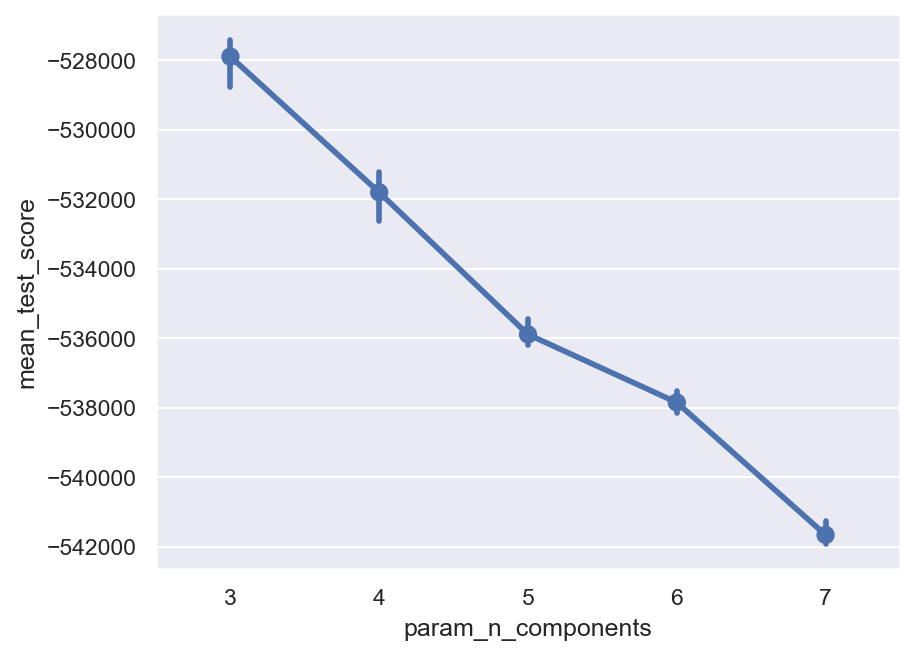

In [30]:
# Visualize the results
cv_results_df = pd.DataFrame(gridsearch.cv_results_)
print(cv_results_df)

sb.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sb.pointplot(x="param_n_components",
              y="mean_test_score",
              data=cv_results_df)

In [31]:
# Apply the best topic number found
num_topics = 3
lda_model1 = LatentDirichletAllocation(n_components=num_topics, random_state=0, 
                                     learning_method='online', learning_decay= 0.6)
LDA_DH_Model1 = lda_model1.fit_transform(DF1)

#check the shape of the Topic-Document Matrix 
print("SIZE of TDM Based on DF1: ", LDA_DH_Model1.shape)

## Check model performance
# log-likelihood
print("\nLog-likelihood: ", lda_model1.score(DF1))
# perplexity
print("\nPerplexity: ", lda_model1.perplexity(DF1))

SIZE of TDM Based on DF1:  (12720, 3)

Log-likelihood:  -2445557.43144064

Perplexity:  2252.742758529369


In [32]:
## Check documents by topic
doc_topic_df1 = pd.DataFrame(LDA_DH_Model1, columns=['T0', 'T1', 'T2'])
print(doc_topic_df1[:10])

## The probability of words over vocabulary
topic_word_matrix1 = lda_model1.components_
topic_word_df1 = pd.DataFrame(topic_word_matrix1, columns=ColumnNames1)
print(topic_word_df1)

         T0        T1        T2
0  0.118289  0.686960  0.194750
1  0.042385  0.044681  0.912935
2  0.149213  0.398496  0.452291
3  0.015030  0.969432  0.015538
4  0.418438  0.487838  0.093724
5  0.256402  0.346635  0.396963
6  0.097954  0.713437  0.188609
7  0.009156  0.608682  0.382162
8  0.088541  0.591680  0.319779
9  0.078454  0.902592  0.018954
   abandoned  abbreviation       abc      abide    ability       abit  \
0   5.106043      0.569272  0.344804   0.374276   0.408878   0.662152   
1   9.631952     13.167732  0.417342  14.172249  33.378170  10.620183   
2   0.345161      0.384679  4.978903   0.414680  14.073369   0.377102   

         able  abomination   abortion    abraham  ...    youtube     youve  \
0    8.694503     0.344599   0.347388  12.781497  ...   0.362834  0.334239   
1  180.299273     0.379364  21.394105   0.445972  ...  24.041565  8.023847   
2    0.461117     4.823625   0.337973   0.354352  ...   3.243753  0.473635   

    yugoslav  yugoslavia   zealand       z

In [34]:
## Get top N words in each topic
## implement a print function
## REF: https://nlpforhackers.io/topic-modeling/
def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names_out()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])
    
## Print LDA using print function from above
print("LDA Model:")
print_topics(lda_model1, UniCountVect)

LDA Model:
Topic 0:
[('gay', 791.7475106152247), ('vandalism', 694.8792191949839), ('pig', 615.0017453510918), ('super', 373.4513523851848), ('wanker', 369.8443616447702), ('moron', 308.66325852844176), ('hitler', 274.1579015855603), ('rules', 274.0337376253409), ('old', 262.09796916630677), ('hey', 236.46653869288576)]
Topic 1:
[('article', 3804.939218089876), ('wikipedia', 2136.8845804332627), ('just', 1729.61892520706), ('people', 1534.447735394729), ('know', 1306.266711251555), ('don', 1289.3201327445468), ('think', 1203.593124226529), ('page', 1150.0571362002247), ('articles', 1148.5661926194377), ('like', 1078.124074583084)]
Topic 2:
[('page', 2226.035112978821), ('talk', 1816.8737260255912), ('wikipedia', 1529.0807655606488), ('like', 1447.3195571522274), ('edit', 984.7796143750305), ('user', 801.7694370900921), ('wiki', 789.1800624216457), ('stop', 781.6093339310314), ('image', 781.5405883277607), ('pages', 729.1515126578172)]


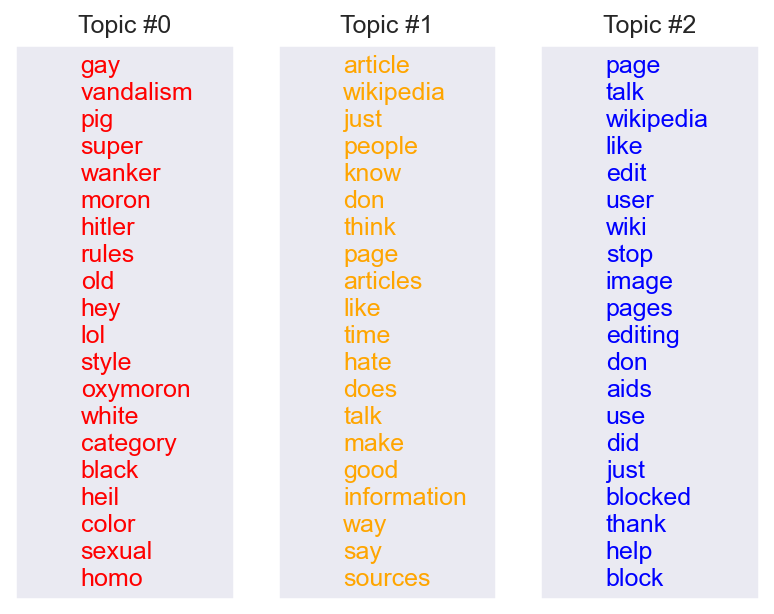

In [46]:
################ Visulization for the first LDA Model

word_topic = np.array(lda_model1.components_)
#print(word_topic)
word_topic = word_topic.transpose()

num_top_words = 20
vocab_array = np.asarray(ColumnNames1)
colors = ["red", "orange", "blue"]

#fontsize_base = 70 / np.max(word_topic) # font size for word with largest share in corpus
fontsize_base = 12
for t in range(num_topics):
    plt.subplot(1, num_topics, t + 1)  # plot numbering starts with 1
    plt.ylim(0, num_top_words + 0.5)  # stretch the y-axis to accommodate the words
    plt.xticks([])  # remove x-axis markings ('ticks')
    plt.yticks([]) # remove y-axis markings ('ticks')
    plt.title('Topic #{}'.format(t))
    top_words_idx = np.argsort(word_topic[:,t])[::-1]  # descending order
    top_words_idx = top_words_idx[:num_top_words]
    top_words = vocab_array[top_words_idx]
    top_words_shares = word_topic[top_words_idx, t]
    for i, (word, share) in enumerate(zip(top_words, top_words_shares)):
        plt.text(0.3, num_top_words-i-0.5, word, fontsize=fontsize_base, color = colors[t])
                 ##fontsize_base*share)
plt.show()

In [38]:
################ Another vis for LDA to plot the relations between topics
import pyLDAvis.sklearn as LDAvis
import pyLDAvis
pyLDAvis.enable_notebook() ## not using notebook
panel = LDAvis.prepare(lda_model1, X1, UniCountVect,  mds='tsne')
pyLDAvis.save_html(panel, "InterTopicMap_DF1.html")

############ Additional evaluation
## create a list that saves the LDA topics
lda_topics1 = []

for i in range(0,LDA_DH_Model1.shape[0]):
    topic_index = np.argmax(LDA_DH_Model1[i])
    lda_topics1.append(str(topic_index))

values, topic_counts1 = np.unique(lda_topics1, return_counts=True)

print("Number of records in each topic: ", topic_counts1)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LatentDirichletAllocation was fitted with feature names
  warnings.warn(


Number of records in each topic:  [1101 8021 3598]


/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [39]:
############ Using DF with Lemmatization

### Code below could be skipped due to the time needed for parameter tuning process
### Search for the topic number

# Options to try for the LDA
search_params = {'n_components': range(3,8),'learning_decay': [.6,.7,.8]}

# Set up LDA with the options keep static, using 'online' method for large data set
model = LatentDirichletAllocation(learning_method='online',
                                  random_state=0)

# Try all of the options
gridsearch = GridSearchCV(model,
                          param_grid=search_params,
                          n_jobs=-1,
                          verbose=1)
gridsearch.fit(DF2)

## Save the best model
best_lda2 = gridsearch.best_estimator_

print("Best Model's Params: ", gridsearch.best_params_)
print("Best Log Likelihood Score: ", gridsearch.best_score_)
print('Best Model Perplexity: ', best_lda2.perplexity(DF2))

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__v

/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__v

/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__v

/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__v

Best Model's Params:  {'learning_decay': 0.6, 'n_components': 3}
Best Log Likelihood Score:  -519208.1895989893
Best Model Perplexity:  1884.706625431696


<AxesSubplot:xlabel='param_n_components', ylabel='mean_test_score'>

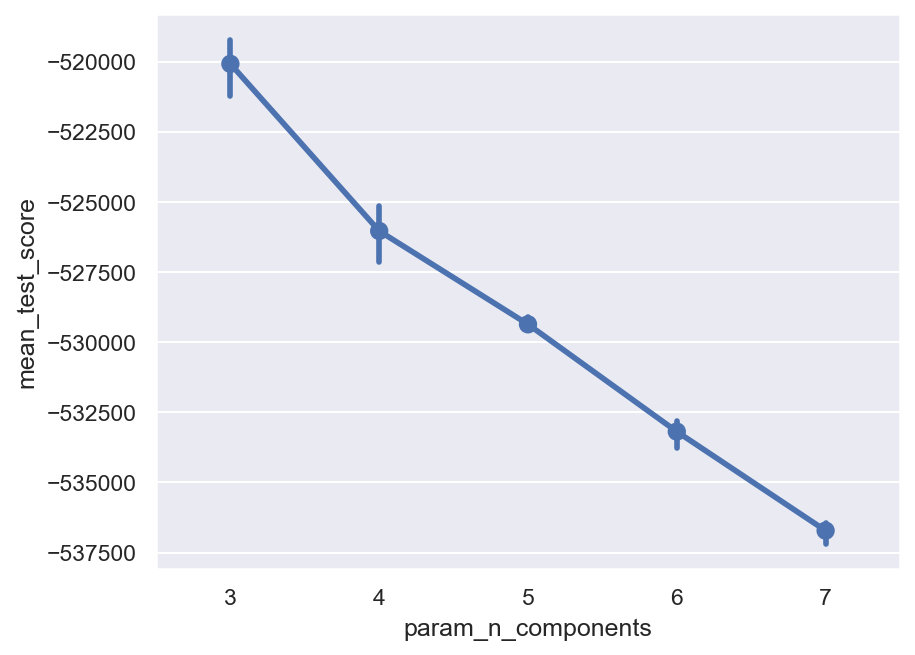

In [40]:
# Visualize the results
cv_results_df2 = pd.DataFrame(gridsearch.cv_results_)

sb.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sb.pointplot(x="param_n_components",
              y="mean_test_score",
              data=cv_results_df2)

In [42]:
# Apply the best topic number found
num_topics = 3
lda_model2 = LatentDirichletAllocation(n_components=num_topics, random_state=0, 
                                       learning_method = 'online', learning_decay= 0.6)
LDA_DH_Model2 = lda_model2.fit_transform(DF2)

#check the shape of the Topic-Document Matrix 
print("SIZE of TDM Based on DF2: ", LDA_DH_Model2.shape)

## Check model performance
# log-likelihood
print("\nLog-likelihood: ", lda_model2.score(DF2))
# perplexity
print("\nPerplexity: ", lda_model2.perplexity(DF2))

SIZE of TDM Based on DF2:  (12720, 3)

Log-likelihood:  -2412504.4655910567

Perplexity:  1884.706625431696


In [43]:
## Check documents by topic
doc_topic_df2 = pd.DataFrame(LDA_DH_Model2, columns=['T0', 'T1', 'T2'])
print(doc_topic_df2[:10])

## The probability of words over vocabulary
topic_word_matrix2 = lda_model2.components_
topic_word_df2 = pd.DataFrame(topic_word_matrix2, columns=ColumnNames2)
print(topic_word_df2)

         T0        T1        T2
0  0.018277  0.418626  0.563097
1  0.915549  0.042221  0.042230
2  0.661032  0.017097  0.321871
3  0.829343  0.014490  0.156167
4  0.384388  0.606341  0.009271
5  0.655030  0.058583  0.286387
6  0.491847  0.501661  0.006492
7  0.612989  0.009848  0.377164
8  0.579537  0.337044  0.083419
9  0.860768  0.122183  0.017049
   abandoned  abbreviation       abc      abide    ability       abit  \
0   6.442724     13.007133  5.018564   0.373582   0.420370   0.524029   
1   8.275886      0.664987  0.371470   0.483640  30.083127  10.789787   
2   0.364545      0.449564  0.351015  14.103982  19.115956   0.345621   

         able  abomination   abortion    abraham  ...    youtube     youve  \
0  122.664014     4.851788   0.363153   0.574388  ...   0.393974  8.031084   
1   61.640156     0.353090  21.374572  13.678987  ...  26.907537  0.440917   
2    5.150723     0.342710   0.341741   0.391429  ...   0.346642  0.359720   

    yugoslav  yugoslavia   zealand       z

In [44]:
## Get top N words in each topic
## Print LDA using print function from above
print("LDA Model:")
print_topics(lda_model2, UniCountVect_Lemma)

LDA Model:
Topic 0:
[('just', 2147.8670324134982), ('don', 1867.7335660334738), ('know', 1765.5610060984723), ('like', 1503.7052051752119), ('think', 1268.0847314294235), ('people', 1215.7021851649988), ('wikipedia', 1114.1428334968105), ('time', 981.8206762691258), ('hate', 930.8901540822632), ('make', 864.0661290045209)]
Topic 1:
[('article', 2251.6812320770955), ('source', 1081.8583365915017), ('like', 735.322841477755), ('aid', 713.0230576283951), ('section', 649.8883116650435), ('fact', 626.0109818428227), ('people', 542.120845330942), ('point', 528.0476288640042), ('doe', 523.8276409979526), ('state', 474.2374866397198)]
Topic 2:
[('page', 3501.400064234569), ('wikipedia', 2437.688340455305), ('article', 2393.4665926158996), ('talk', 2345.8109415621043), ('edit', 1052.7885787140137), ('image', 1017.4603649539938), ('use', 810.1029091075185), ('gay', 801.5710985148845), ('edits', 756.732786889672), ('user', 748.0024565091891)]


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


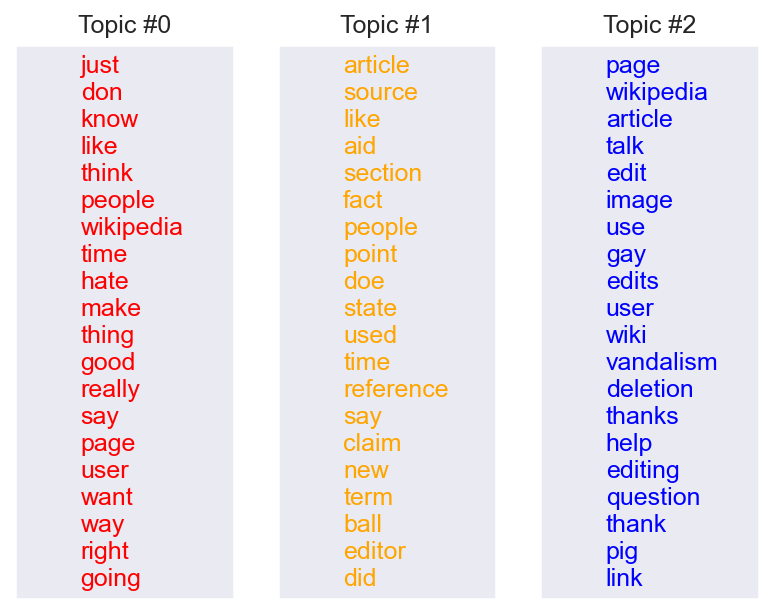

In [45]:
################ Visulization for the second LDA model using lemmatized words

word_topic2 = np.array(lda_model2.components_)
#print(word_topic2)
word_topic2 = word_topic2.transpose()

num_top_words = 20
vocab_array = np.asarray(ColumnNames2)

#fontsize_base = 70 / np.max(word_topic2) # font size for word with largest share in corpus
fontsize_base = 12

colors = ["red", "orange", "blue"]

for t in range(num_topics):
    plt.subplot(1, num_topics, t + 1)  # plot numbering starts with 1
    plt.ylim(0, num_top_words + 0.5)  # stretch the y-axis to accommodate the words
    plt.xticks([])  # remove x-axis markings ('ticks')
    plt.yticks([]) # remove y-axis markings ('ticks')
    plt.title('Topic #{}'.format(t))
    top_words_idx = np.argsort(word_topic2[:,t])[::-1]  # descending order
    top_words_idx = top_words_idx[:num_top_words]
    top_words = vocab_array[top_words_idx]
    top_words_shares = word_topic2[top_words_idx, t]
    for i, (word, share) in enumerate(zip(top_words, top_words_shares)):
        plt.text(0.3, num_top_words-i-0.5, word, fontsize=fontsize_base, color = colors[t])
                 ##fontsize_base*share)
plt.show()

In [ ]:
#create another visualization to plot the relations between topics
pyLDAvis.enable_notebook() ## not using notebook
panel = LDAvis.prepare(lda_model2, X2, UniCountVect_Lemma,  mds='tsne')
pyLDAvis.save_html(panel, "InterTopicMap_DF2.html")

## create a list that saves the LDA topic labels
lda_labels = []

for i in range(0,LDA_DH_Model2.shape[0]):
    topic_index = np.argmax(LDA_DH_Model2[i])
    lda_labels.append(str(topic_index))

values, label_counts = np.unique(lda_labels, return_counts=True)

print(lda_labels)
print("Number of records in each topic: ", label_counts)
